<a href="https://colab.research.google.com/github/emmanuellfc/EM_Tufts_Fall2023/blob/main/GeneralFiniteDifferences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Package dependencies.
!apt install libcgal-dev libeigen3-dev
!pip install -U pygalmesh
!pip install networkx

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgmp-dev libgmpxx4ldbl libmpfr-dev
Suggested packages:
  libmpfi-dev libntl-dev libeigen3-doc libmpfrc++-dev gmp-doc libgmp10-doc libmpfr-doc
The following NEW packages will be installed:
  libcgal-dev libeigen3-dev libgmp-dev libgmpxx4ldbl libmpfr-dev
0 upgraded, 5 newly installed, 0 to remove and 9 not upgraded.
Need to get 6,457 kB of archives.
After this operation, 52.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgmpxx4ldbl amd64 2:6.2.1+dfsg-3ubuntu1 [9,580 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgmp-dev amd64 2:6.2.1+dfsg-3ubuntu1 [337 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmpfr-dev amd64 4.1.0-3build3 [271 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcgal-dev amd64 5.4-1 [4,784 kB]
Get:5 http://archive.ub

In [ ]:
# Imports.
import pygalmesh
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colormaps as cmaps
from typing import Iterable
from typing import Callable
from typing import Optional
import math

In [ ]:
# Rperesents an individual node of the graph data structure representation of the mesh.
class MeshPoint: pass
class MeshPoint:
  def __init__(self,pos: tuple = (0,0)):
    self.pos = tuple(pos) # (x,y) position of the node.
    self.pot: Optional[float] = None # Solution of potential for this node point.
  def __getitem__(self,index):
    return self.pos[index]
  def __eq__(self,other: MeshPoint):
    return self.pos is other.pos
  def __hash__(self):
    return hash(self.pos)

  # The "gamma" function is one half the sum of inverse square distances between these points. i.e. 0.5(1/(x1-x2)^2 + 1/(y1-y2)^2).
  def gamma(self,other: MeshPoint) -> float:
    if  len(self.pos) is not len(other.pos):
      raise Exception('Incompatable dimensionality computing gamma: ' + self.pos + ' and ' + other.pos)
    tmp: float = 0
    for dim in range(len(self.pos)):
      # Don't divide by 0.
      if math.isclose(self.pos[dim],other.pos[dim]): continue
      tmp += pow(self.pos[dim]-other.pos[dim],-2)
    return tmp/2

# Represents a mesh (contains a graph) for the system we're trying to solve.
class FiniteDifferences:
  def __init__(self):
    self.edge_points: list = None # List of (x,y) points that form the boundary of the 2D space.
    self.mesh = None # Pygalmesh mesh object.
    self.mesh_points: list = None # List of (x,y) points that form the region of 2D space.
    self.graph = nx.Graph() # Graph data structure representing the region. Nodes of the graph are MeshPoint objects.
    self.boundary_conditions: Callable[[MeshPoint],Optional[float]] = None # Not sure what the elements of this will look like yet.
    self.systems_matrix = None # m x m matrix where m is the number of points in the space.
    self.systems_rhs = None # m x 1 vector that serves as the right hand side of the system of linear equations.
    self.solution = None # Solution result of the systems matrix.

  # Make a list of points from some edge conditions. This makes a surface "mesh" from a boundary definition. The boundary is a list of points.
  def make_points_from_boundary(self,boundary: Iterable[tuple]):
    # First, store the edge points that we were passed.
    self.edge_points = list(boundary)
    # The constraints we pass to pygalmesh need to look like [(0,1),(1,2),...(n-2,n-1),(n-1,0)]. The last constraint closes the boundary.
    constraints = [ (i-1,i) for i in range(1,len(self.edge_points)) ] + [(len(self.edge_points)-1,0)]
    # Ask pygalmesh to make a mesh for us.
    self.mesh = pygalmesh.generate_2d(
      self.edge_points,
      constraints,
      max_edge_size=4e-1,
      num_lloyd_steps=10,
    )
    # Store the points from this mesh as MeshPoint objects.
    self.mesh_points = [ MeshPoint(pt) for pt in self.mesh.points ]

  # Inform the method of boundary conditions that exist for the problem.
  # We expect a function that takes a MeshPoint object and returns a boundary potential for it if it should have one. Expects None for "not a boundary point."
  def inform_with_boundary_conditions(self,conditions: Callable[[MeshPoint],Optional[float]]):
    self.boundary_conditions = conditions

  # Only callable once a mesh exists. Build a graph data structure from a list of points. Don't make neighbors out of points that are too far away.
  def make_graph_from_points(self):
    # First, add all mesh points to the graph as nodes.
    for point in self.mesh_points:
      self.graph.add_node(point)
    # Now, for each point...
    for point in self.mesh_points:
      # Get gamma values for all of the other points...
       # This makes a copy of our point list with the closest gamma points first. NEARER points have LARGER gamma values.
      points_gammas = sorted(self.mesh_points,key=lambda other_point: point.gamma(other_point),reverse=True)
      # Keep the nearest 10 points... TODO: Make this more general/parametrized?
      # Add edges between this point and "nearby" points.
      for other_point in points_gammas[:3]:
        if point == other_point: continue # Don't try to link a point to itself! (This shouldn't really be possible.)
        # Make the edge between these points.
        self.graph.add_edge(point,other_point,gamma=point.gamma(other_point))

  # Only callable once a graph exists. Make the C matrix element by element.
  def make_systems_matrix(self):
    # Before initializing the systems matrix, get all boundary conditions.
    # We do this because we need to know how many conditions we will have before building the systems matrix.
    if self.boundary_conditions is None:
      raise Exception('Must inform with boundary conditions before constructing the systems matrix.')
    nconditions = 0 # Remember how many boundary conditions we have.
    for point in self.mesh_points:
      condition_pot: Optional[float] = self.boundary_conditions(point)
      # We now know what the boundary potential for this point is.
      if condition_pot is not None:
        point.pot = condition_pot
        nconditions += 1

    # Initialize the systems matrix to the correct size (m x m where m is our number of points + the number of boundary conditions we have).
    primary_size = len(self.mesh_points)
    m = primary_size + nconditions
    self.systems_matrix = np.array([np.zeros(m) for j in range(0,m)])
    self.systems_rhs = np.zeros(m)
    # c_{i,i} = -1, so fill that diagonal now.
    for i in range(0,m): self.systems_matrix[i][i] = -1
    # Iterate over nodes of the graph...
    for i_point,point in enumerate(self.mesh_points):
      # ... and get the edges for this point (its neighbors).
      # For each of these, c_{i,j} = gamma_{i,j} / (k el neighbors(i) sum gamma_{i,k}).
      # self.graph[point] is a dict of { neighbor_point : attributes } elements. We expect attributes to contain a gamma attribute.
      neighbors = self.graph[point]
      # First get the gamma sum for this point (depends on all neighbors).
      gamma_sum: float = 0
      for neighbor in neighbors:
        gamma_sum += self.graph[point][neighbor]['gamma']
      # Iterate over neighbors now and fill in c_{i,j} elements.
      for neighbor in neighbors:
        # What is the index of the neighbor?
        i_neighbor = self.mesh_points.index(neighbor)
        self.systems_matrix[ i_point ][ i_neighbor ] = self.graph[point][neighbor]['gamma'] / gamma_sum
    # Add all boundary conditions to the systems matrix. Each unique condition will add one row to the matrix.
    condition_index = 0
    for i_point,point in enumerate(self.mesh_points):
      # Each boundary condition should look like: 1 * x_i = pot_i...
      if point.pot is None: continue # This point isn't associated with a boundary condition.
      self.systems_matrix[ condition_index + primary_size ][ i_point ] = 1
      self.systems_rhs[ condition_index + primary_size ] = point.pot
      condition_index += 1

  # Only callable once a C matrix exists. Try to solve the C matrix.
  def solve_systems_matrix(self):
    self.solution = np.linalg.solve(self.systems_matrix,self.systems_rhs)
    # Store pot values in our mesh points themselves.
    for i_point,point in enumerate(self.mesh_points):
      point.pot = self.solution[i_point]

  # Profit???

[[-1.  0.  0. ...  0.  0.  0.]
 [ 0. -1.  0. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.  10.  10.  10.  10. -10.
  10. -10.  10.  10. -10. -10.  10.  10. -10.  10. -10.]
[ 2.40816327  2.40816327  2.40816327  2.40816327  2.40816327  2.40816327
  2.40816327  2.40816327  2.40816327  2.40816327  2.40816327  2.40816327
  2.40816327  2.40816327  2.40816327  2.40816327  2.40816327  2.40816327
  2.40816327  2.40816327  2.40816327  2.40816327  2.40816327 -7.59183673
 -7.59183673 -7.59183673 -7.59183673 12.40816327 -7.59183673 12.40816327
 -7.59183673 -7.59183673 12.40816327 12.40816327 -7.59183673 -7.59183673
 12.40816327 -7.59183673 12.40816327]


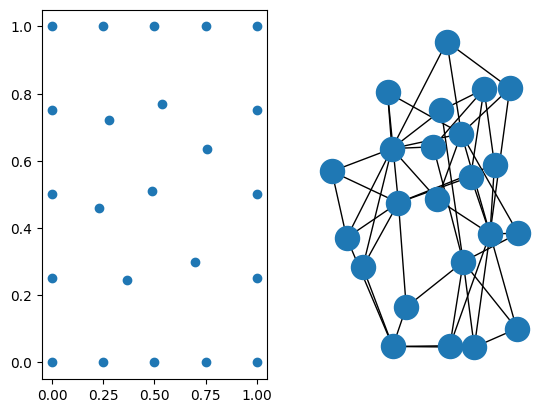

In [ ]:
# Generate the simplest possible boundary: An edge length 1 box.
def box_generator():
  yield (0,0)
  yield (0,1)
  yield (1,1)
  yield (1,0)

solution = FiniteDifferences()
solution.make_points_from_boundary(box_generator())

plt.subplot(121)
plt.scatter([ loc[0] for loc in solution.mesh_points ],[ loc[1] for loc in solution.mesh_points ])

solution.make_graph_from_points()

plt.subplot(122)
nx.draw(solution.graph)

def stupid_boundary(point: MeshPoint) -> Optional[float]:
  if point.pos[0] < 0.05: return 10
  if point.pos[0] > 0.95: return 10
  if point.pos[1] < 0.05: return -10
  if point.pos[1] > 0.95: return -10
  return None

solution.inform_with_boundary_conditions(stupid_boundary)

solution.make_systems_matrix()

#with np.printoptions(threshold=np.inf):
print(solution.systems_matrix)
print(solution.systems_rhs)

solution.solve_systems_matrix()
print(solution.solution)